Data Anomaly Detection (Toca Boca: Part 1)
===

## Objective
Explore the datasets focusing on finding any issues within the
data, and write down a short summary of your findings. If you find any problems, what
possible causes can you think of?

## Key Issues Found:

**Overview**</br>
* **Missing in-app-purchase data:** We see that `in-app-purchase` data for the "Racing App" was not available after January 2021. One possible explanation is that in-app-purchases were no longer available after that date, but after investigating the `sales_from_appstores` data we can confirm that users were still making in-app purchases.
* **Decline in triggered events:** We see a decline in trigerred events that started around January 2021 (stabilized February 2021). This decline is significant, and after looking at the `sales_from_appstores` data we can confirm that users were still downloading the app and making in-app purchases during that time, therefore the issue may come from the event analytics tool (e.g. Problem with Firebase SDK integration).

**User Level:**<br>
Issues specific to the user level data
* **Duplicates:** Since the data is aggregated at the daily level (no timestamp) and there is no UUID, its difficult to determine if duplicate events are simply due to the same event being triggered multiple times by the same user or if there is infact duplicates in the data. But you can't clear the same level twice. 
* **Missing countries:** The missing countries could be due to several factors:
    * If country info comes from user registration then this information may not be available because users never provided the information
    * If country info comes from the location where the event was triggered, then different technical issues may make it difficult to extract this data.
* **Spike in level events:** Huge spike in level events (`level_started and level_cleared`) triggered on March 17, 2020. Looks like this spike can be attributed to a single user who started around 788 events on that day. This was user `4c35e1d1-20c4-412f-8b81-1b273fe61f69`.


**Appstore Level**<br>
Issues specific to the app store data
* **Drawing App download decline:** The "Drawing App" we seemed to stop getting downloads around September 2023, unlike for "Racing App" and "Fun App" which continued to get downloads until December 2023

# 1. Import

In [229]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

cdw = os.getcwd()

In [33]:
def read_data(filename):
    file_path = cdw + os.sep + filename
    df = pd.read_csv(file_path)

    return df

In [337]:
app_closed_df = read_data("app_closed.csv")
app_started_df = read_data("app_started.csv")
in_app_purchase_df = read_data("in_app_purchase.csv")
level_cleared_df = read_data("level_cleared.csv")
level_started_df = read_data("level_started.csv")
sales_from_appstores_df = read_data("sales_from_appstores.csv")

# 2. Pre-process

In [43]:
def check_data(df):
    # Generates a concise summary of DataFrame columns.
    
    # We use list comprehension to iterate over each column
    summary = [
        [col, df[col].dtype, df[col].count(), df[col].nunique(), df[col].isnull().sum(), df.duplicated().sum()]
        for col in df.columns
    ]
    # Create a DataFrame from the list of lists
    df_check = pd.DataFrame(summary, columns=["column", "dtype", "instances", "unique", "sum_null", "duplicates"])

    return df_check

In [103]:
# Join all datasets
user_level_df = pd.concat(
    [app_closed_df,
     in_app_purchase_df,
     app_started_df,
     level_started_df,
     level_cleared_df]
    , axis=0, ignore_index=True)

In [259]:
# Change 'dt' colum to date type
user_level_df['dt'] = pd.to_datetime(user_level_df['dt'])

In [343]:
sales_from_appstores_df['dt'] = pd.to_datetime(sales_from_appstores_df['dt'])

# 3. Analysis

## User Level

### Individual Check
Checking each dataset individual to see if we spot any anomalies

In [65]:
display("App Closed", app_closed_df.head(5), app_closed_df.tail(5), app_closed_df.shape)

'App Closed'

,event_name,dt,user_id,country_iso,platform,app_id,app_name
0,app_closed,2020-01-01,c467189f-ef05-48a7-8d2e-13444df3a971,EE,Cyborg,30,Racing App
1,app_closed,2020-01-01,ffdf6fef-4437-4eee-85c2-488133fe1cff,BB,Pear,30,Racing App
2,app_closed,2020-01-01,e1716521-b8f2-4c34-a4c0-939c33297921,CC,Cyborg,30,Racing App
3,app_closed,2020-01-01,57c9dfeb-2cdd-424c-a48b-4175a329b3ed,EE,Cyborg,30,Racing App
4,app_closed,2020-01-01,57c9dfeb-2cdd-424c-a48b-4175a329b3ed,EE,Cyborg,30,Racing App


,event_name,dt,user_id,country_iso,platform,app_id,app_name
13761,app_closed,2021-10-03,872587bc-6330-491d-b695-e769e04416d8,DD,Cyborg,30,Racing App
13762,app_closed,2021-10-04,872587bc-6330-491d-b695-e769e04416d8,DD,Cyborg,30,Racing App
13763,app_closed,2021-10-04,872587bc-6330-491d-b695-e769e04416d8,DD,Cyborg,30,Racing App
13764,app_closed,2021-10-06,872587bc-6330-491d-b695-e769e04416d8,DD,Cyborg,30,Racing App
13765,app_closed,2021-10-11,872587bc-6330-491d-b695-e769e04416d8,DD,Cyborg,30,Racing App


(13766, 7)

In [52]:
check_data(app_closed_df)

,column,dtype,instances,unique,sum_null,duplicates
0,event_name,object,13766,1,0,5136
1,dt,object,13766,548,0,5136
2,user_id,object,13766,2974,0,5136
3,country_iso,object,13378,5,388,5136
4,platform,object,13766,2,0,5136
5,app_id,int64,13766,1,0,5136
6,app_name,object,13766,1,0,5136


In [66]:
display("App Started", app_started_df.head(5), app_started_df.tail(5), app_started_df.shape)

'App Started'

,event_name,dt,user_id,country_iso,platform,app_id,app_name
0,app_started,2020-01-01,67f4fd27-22a5-497d-aaad-43023af7a063,EE,Cyborg,30,Racing App
1,app_started,2020-01-01,c467189f-ef05-48a7-8d2e-13444df3a971,EE,Cyborg,30,Racing App
2,app_started,2020-01-01,ffdf6fef-4437-4eee-85c2-488133fe1cff,BB,Pear,30,Racing App
3,app_started,2020-01-01,e1716521-b8f2-4c34-a4c0-939c33297921,CC,Cyborg,30,Racing App
4,app_started,2020-01-01,57c9dfeb-2cdd-424c-a48b-4175a329b3ed,EE,Cyborg,30,Racing App


,event_name,dt,user_id,country_iso,platform,app_id,app_name
13421,app_started,2021-10-03,872587bc-6330-491d-b695-e769e04416d8,DD,Cyborg,30,Racing App
13422,app_started,2021-10-04,872587bc-6330-491d-b695-e769e04416d8,DD,Cyborg,30,Racing App
13423,app_started,2021-10-04,872587bc-6330-491d-b695-e769e04416d8,DD,Cyborg,30,Racing App
13424,app_started,2021-10-06,872587bc-6330-491d-b695-e769e04416d8,DD,Cyborg,30,Racing App
13425,app_started,2021-10-11,872587bc-6330-491d-b695-e769e04416d8,DD,Cyborg,30,Racing App


(13426, 7)

In [54]:
check_data(app_started_df)

,column,dtype,instances,unique,sum_null,duplicates
0,event_name,object,13426,1,0,4955
1,dt,object,13426,546,0,4955
2,user_id,object,13426,2951,0,4955
3,country_iso,object,13022,5,404,4955
4,platform,object,13426,2,0,4955
5,app_id,int64,13426,1,0,4955
6,app_name,object,13426,1,0,4955


In [67]:
display("In App Purchase", in_app_purchase_df.head(5), in_app_purchase_df.tail(5), in_app_purchase_df.shape)

'In App Purchase'

,event_name,dt,user_id,price,content_id,country_iso,platform,app_id,app_name
0,in_app_purchase,2020-01-01,57c9dfeb-2cdd-424c-a48b-4175a329b3ed,1.99,app.raceapp.redcar,EE,Cyborg,30,Racing App
1,in_app_purchase,2020-01-02,915e55e7-7e9c-40b7-9459-77e945b3e511,2.99,app.raceapp.silvercar,CC,Cyborg,30,Racing App
2,in_app_purchase,2020-01-02,57c9dfeb-2cdd-424c-a48b-4175a329b3ed,1.99,app.raceapp.whitecar,EE,Cyborg,30,Racing App
3,in_app_purchase,2020-01-03,50a14af1-d6ed-487f-9653-f224c9363249,0.99,app.raceapp.bluecar,AA,Cyborg,30,Racing App
4,in_app_purchase,2020-01-04,e44b2941-4a1d-4941-874c-c72b9e53b9e8,1.99,app.raceapp.whitecar,DD,Cyborg,30,Racing App


,event_name,dt,user_id,price,content_id,country_iso,platform,app_id,app_name
269,in_app_purchase,2020-12-22,170e66e2-25e4-4e72-a0e1-fd86e77fe36e,2.99,app.raceapp.silvercar,DD,Cyborg,30,Racing App
270,in_app_purchase,2020-12-23,170e66e2-25e4-4e72-a0e1-fd86e77fe36e,1.99,app.raceapp.redcar,NaN,Cyborg,30,Racing App
271,in_app_purchase,2020-12-24,170e66e2-25e4-4e72-a0e1-fd86e77fe36e,0.99,app.raceapp.bluecar,DD,Cyborg,30,Racing App
272,in_app_purchase,2020-12-25,e8f32674-4995-4019-8f2b-6f54858fbae4,0.99,app.raceapp.bluecar,DD,Cyborg,30,Racing App
273,in_app_purchase,2020-12-30,f21a200e-ece4-4fcd-be66-714716eb0592,1.99,app.raceapp.redcar,EE,Cyborg,30,Racing App


(274, 9)

In [55]:
check_data(in_app_purchase_df)

,column,dtype,instances,unique,sum_null,duplicates
0,event_name,object,274,1,0,10
1,dt,object,274,193,0,10
2,user_id,object,274,193,0,10
3,price,float64,274,6,0,10
4,content_id,object,274,4,0,10
5,country_iso,object,268,5,6,10
6,platform,object,274,2,0,10
7,app_id,int64,274,1,0,10
8,app_name,object,274,1,0,10


In [68]:
display("Level Cleared", level_cleared_df.head(5), level_cleared_df.tail(5), level_cleared_df.shape)

'Level Cleared'

,event_name,dt,user_id,level_nr,country_iso,platform,app_id,app_name
0,level_cleared,2020-01-01,67f4fd27-22a5-497d-aaad-43023af7a063,440.0,EE,Cyborg,30,Racing App
1,level_cleared,2020-01-01,67f4fd27-22a5-497d-aaad-43023af7a063,441.0,EE,Cyborg,30,Racing App
2,level_cleared,2020-01-01,67f4fd27-22a5-497d-aaad-43023af7a063,442.0,EE,Cyborg,30,Racing App
3,level_cleared,2020-01-01,ffdf6fef-4437-4eee-85c2-488133fe1cff,798.0,BB,Pear,30,Racing App
4,level_cleared,2020-01-01,ffdf6fef-4437-4eee-85c2-488133fe1cff,799.0,BB,Pear,30,Racing App


,event_name,dt,user_id,level_nr,country_iso,platform,app_id,app_name
52137,level_cleared,2021-10-11,872587bc-6330-491d-b695-e769e04416d8,804.0,DD,Cyborg,30,Racing App
52138,level_cleared,2021-10-11,872587bc-6330-491d-b695-e769e04416d8,805.0,DD,Cyborg,30,Racing App
52139,level_cleared,2021-10-11,872587bc-6330-491d-b695-e769e04416d8,806.0,DD,Cyborg,30,Racing App
52140,level_cleared,2021-10-11,872587bc-6330-491d-b695-e769e04416d8,807.0,DD,Cyborg,30,Racing App
52141,level_cleared,2021-10-11,872587bc-6330-491d-b695-e769e04416d8,808.0,DD,Cyborg,30,Racing App


(52142, 8)

In [56]:
check_data(level_cleared_df)

,column,dtype,instances,unique,sum_null,duplicates
0,event_name,object,52142,1,0,402
1,dt,object,52142,550,0,402
2,user_id,object,52142,4000,0,402
3,level_nr,float64,51987,1777,155,402
4,country_iso,object,50618,5,1524,402
5,platform,object,52142,2,0,402
6,app_id,int64,52142,1,0,402
7,app_name,object,52142,1,0,402


In [69]:
display("Level Started", level_started_df.head(5), level_started_df.tail(5), level_started_df.shape)

'Level Started'

,event_name,dt,user_id,level_nr,country_iso,platform,app_id,app_name
0,level_started,2020-01-01,c467189f-ef05-48a7-8d2e-13444df3a971,995,EE,Cyborg,30,Racing App
1,level_started,2020-01-01,c467189f-ef05-48a7-8d2e-13444df3a971,996,EE,Cyborg,30,Racing App
2,level_started,2020-01-01,ffdf6fef-4437-4eee-85c2-488133fe1cff,798,BB,Pear,30,Racing App
3,level_started,2020-01-01,ffdf6fef-4437-4eee-85c2-488133fe1cff,799,BB,Pear,30,Racing App
4,level_started,2020-01-01,e1716521-b8f2-4c34-a4c0-939c33297921,911,NaN,Cyborg,30,Racing App


,event_name,dt,user_id,level_nr,country_iso,platform,app_id,app_name
52164,level_started,2021-10-11,872587bc-6330-491d-b695-e769e04416d8,807,NaN,Cyborg,30,Racing App
52165,level_started,2021-10-11,872587bc-6330-491d-b695-e769e04416d8,804,DD,Cyborg,30,Racing App
52166,level_started,2021-10-11,872587bc-6330-491d-b695-e769e04416d8,805,DD,Cyborg,30,Racing App
52167,level_started,2021-10-11,872587bc-6330-491d-b695-e769e04416d8,806,DD,Cyborg,30,Racing App
52168,level_started,2021-10-11,872587bc-6330-491d-b695-e769e04416d8,808,DD,Cyborg,30,Racing App


(52169, 8)

In [57]:
check_data(level_started_df)

,column,dtype,instances,unique,sum_null,duplicates
0,event_name,object,52169,1,0,431
1,dt,object,52169,550,0,431
2,user_id,object,52169,4000,0,431
3,level_nr,int64,52169,1778,0,431
4,country_iso,object,50651,5,1518,431
5,platform,object,52169,2,0,431
6,app_id,int64,52169,1,0,431
7,app_name,object,52169,1,0,431


**Observations:**
* All datasets provide event data at the user level.
* All datasets have the same 7 columns with the exception of the following:
    * The `level_started` and `level_cleared` datasets introduce the following column: `level_nr`
    * The `in_app_purchases` dataset introduces two columns: `price` and `content_id`
* All datasets have some duplicate rows and missing values for `country_iso`.
* The dataset `level_cleared` has missing values for `level_nr`

### All datasets
Join all datasets together and continue exploring

In [118]:
user_level_df.head()

,event_name,dt,user_id,country_iso,platform,app_id,app_name,price,content_id,level_nr
0,app_closed,2020-01-01,c467189f-ef05-48a7-8d2e-13444df3a971,EE,Cyborg,30,Racing App,NaN,NaN,NaN
1,app_closed,2020-01-01,ffdf6fef-4437-4eee-85c2-488133fe1cff,BB,Pear,30,Racing App,NaN,NaN,NaN
2,app_closed,2020-01-01,e1716521-b8f2-4c34-a4c0-939c33297921,CC,Cyborg,30,Racing App,NaN,NaN,NaN
3,app_closed,2020-01-01,57c9dfeb-2cdd-424c-a48b-4175a329b3ed,EE,Cyborg,30,Racing App,NaN,NaN,NaN
4,app_closed,2020-01-01,57c9dfeb-2cdd-424c-a48b-4175a329b3ed,EE,Cyborg,30,Racing App,NaN,NaN,NaN


In [143]:
user_level_df.describe()

,dt,app_id,price,level_nr
count,131777,131777.0,274.000000,104156.000000
mean,2020-07-18 02:30:49.979890176,30.0,1.884745,511.933148
min,2020-01-01 00:00:00,30.0,-2.990000,-1.000000
25%,2020-04-07 00:00:00,30.0,0.990000,251.000000
50%,2020-07-18 00:00:00,30.0,1.990000,509.000000
75%,2020-10-19 00:00:00,30.0,2.990000,757.000000
max,2021-10-11 00:00:00,30.0,2.990000,1776.000000
std,NaN,0.0,1.003013,304.548740


In [98]:
def plot_percent_distribution(df, category, plot_title):
    # Calculate distribution of houses per area
    counts = df[category].value_counts().reset_index()
    counts.columns = [category, 'count']
    
    total = counts['count'].sum()
    counts['percentage'] = (counts['count'] / total) * 100
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=category, y='percentage', data=counts)
    #plt.ylim(0, 100)  # Set y-axis limits from 0 to 100
    plt.ylabel('Percentage of Total')
    plt.xlabel(category)
    plt.title(plot_title)
    #plt.xticks(rotation=45, ha='right')
    plt.show()

In [332]:
categorical = ["event_name", "platform", "app_name", "country_iso", "content_id"]

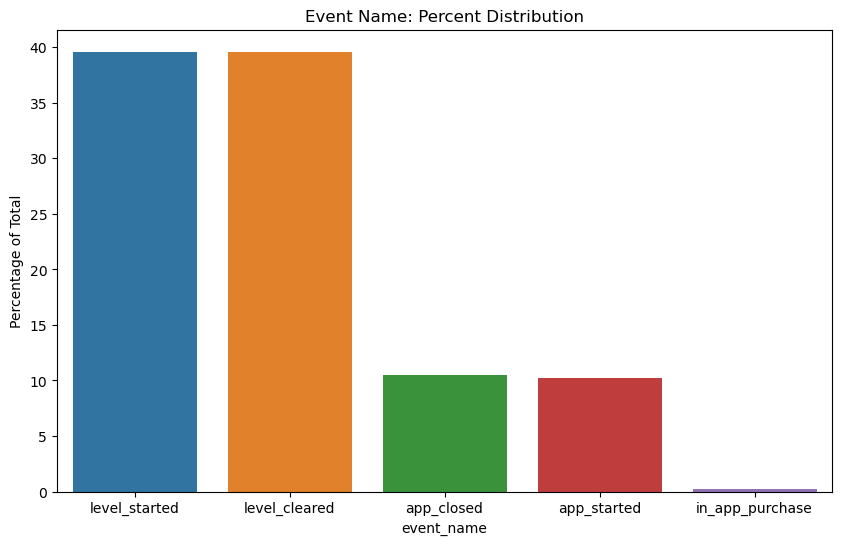

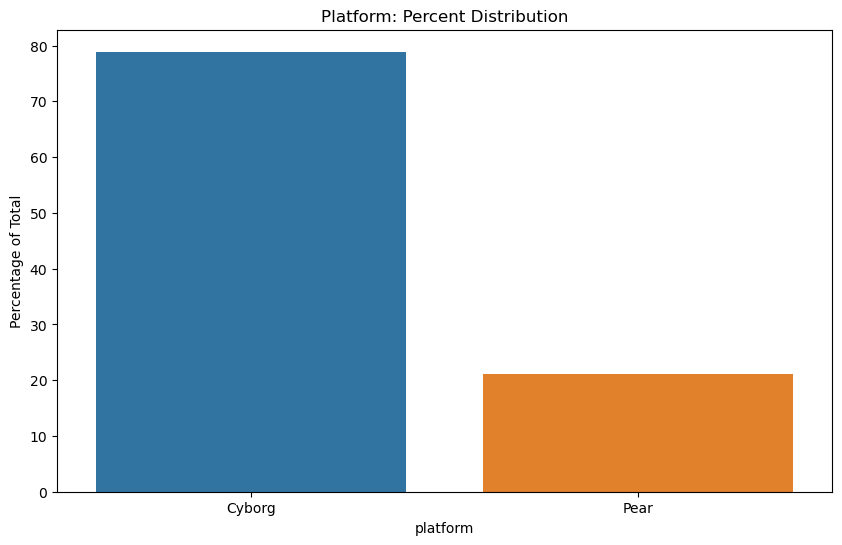

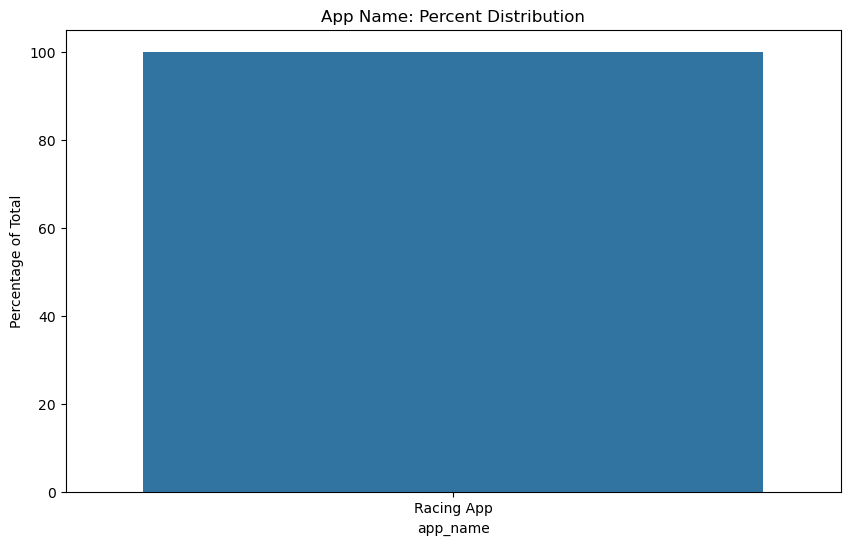

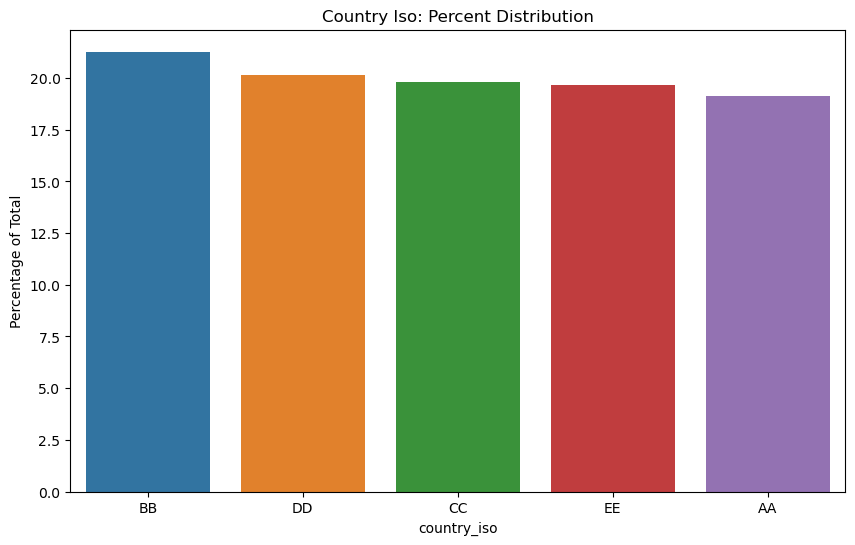

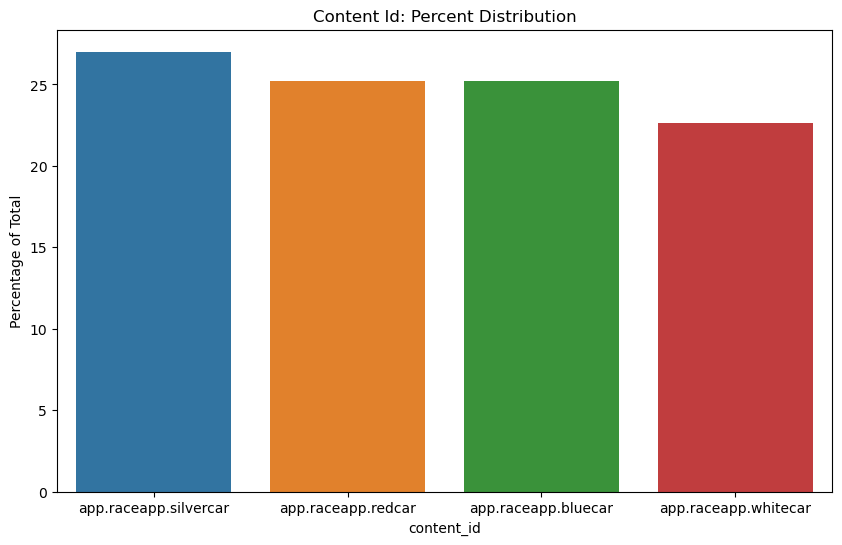

In [333]:
for cat in categorical:
    proper_cat_name = cat.replace('_', ' ').title()
    plot_percent_distribution(user_level_df, cat, f"{proper_cat_name}: Percent Distribution")

In [320]:
event_counts = user_level_df.groupby(['dt', 'event_name']).size().reset_index(name='count')

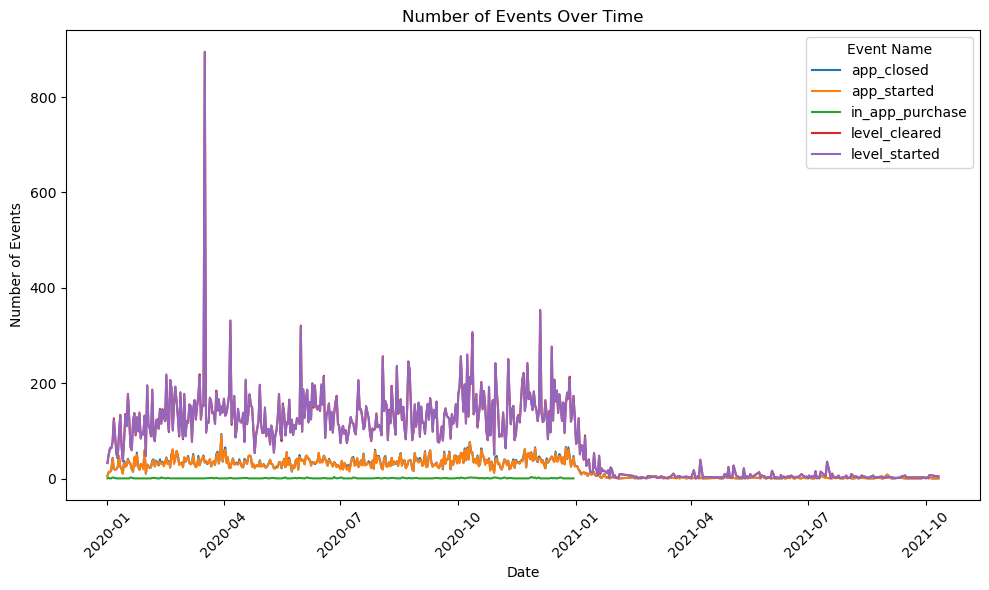

In [230]:
# Plot the data
plt.figure(figsize=(10, 6))
sns.lineplot(data=event_counts, x='dt', y='count', hue='event_name')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.title('Number of Events Over Time')
plt.xticks(rotation=45)
plt.legend(title='Event Name')
plt.tight_layout()
plt.show()

**Observations:**
* Both `app_closed` and `app_started` events overlap, which is expected seeing that these two events are related (and opposite) to each other, once one event is triggered, the other is also expected to be triggered eventually. The same is observed for `level_started` and `level_cleared`
* There is only one year worth of `in_app_purchase` events (between January 2020 and January 2021)
* Right around the same time we stopped getting `in_app_purchase` events, we also see a drastic decline in all of the other events. Around February 2023 the numbers stabilized. 

In [371]:
event_counts[(event_counts['dt'].between("2020-03-12", "2020-03-22")) & (event_counts['event_name'] == 'level_cleared')]

,dt,event_name,count,weekly
329,2020-03-12,level_cleared,173,2020-03-09/2020-03-15
333,2020-03-13,level_cleared,219,2020-03-09/2020-03-15
338,2020-03-14,level_cleared,124,2020-03-09/2020-03-15
342,2020-03-15,level_cleared,152,2020-03-09/2020-03-15
347,2020-03-16,level_cleared,153,2020-03-16/2020-03-22
351,2020-03-17,level_cleared,894,2020-03-16/2020-03-22
355,2020-03-18,level_cleared,97,2020-03-16/2020-03-22
359,2020-03-19,level_cleared,119,2020-03-16/2020-03-22
363,2020-03-20,level_cleared,118,2020-03-16/2020-03-22
367,2020-03-21,level_cleared,170,2020-03-16/2020-03-22


In [373]:
levels_started_per_user = user_level_df[(user_level_df['dt'] == "2020-03-17") & (user_level_df['event_name'] == 'level_started')].groupby(by='user_id')["level_nr"].nunique()
print(levels_started_per_user)

user_id
042db283-eb74-4814-ac1e-f09dfa0c4e04      3
071f918c-3760-4d97-b0f3-adbc3ad1a2ea      2
18680e81-6373-4dc6-b5da-68fe8be2e145      4
27593c70-29eb-43aa-9679-70c2dba26693      2
301b7198-dcac-49ad-ab7c-4b0066486324      3
4c35e1d1-20c4-412f-8b81-1b273fe61f69    788
4d3baf50-29a4-400c-873c-5ae20c1e99b5      2
500e6450-56e8-4b56-96eb-0f5f25f10c82      3
58521a9d-12c9-4a71-89b3-20bc7912ef5e      3
619e3a0e-735d-4939-8ed5-3be2b61e4bd6      3
77f85eb4-069e-4ab1-b20c-f3b5021f4e05      8
84a84778-3334-4ad8-b488-6f66e09668ca      2
860ddf38-815c-4d92-8e78-ccd6ad7d92bc      4
8e4314fc-ecb7-4245-9582-7fe559d5b5fc      3
931f928c-9af0-4735-94a1-6c6be3b282ff      2
94327e47-1efa-4345-a16a-1c50effbf223      4
95969865-4a1d-47fa-9789-aaba765387c0      2
a24a7282-7f3c-4607-91a1-d79f745d990d      2
a29a32c9-f8c6-4492-a619-569c3d72c647      3
a353895f-2436-42b6-9b2a-f14198bc22a6      2
ae02f0b4-e062-49a2-a3fd-60282c8d6221      7
b48e71e5-f853-4b38-864c-b43343e284cd      2
c538f823-dc07-4fbf-8fce-

In [378]:
filtered_df = user_level_df[(user_level_df['dt'] == '2020-03-17') & 
                            (user_level_df['event_name'] == 'level_started') & 
                            (user_level_df['user_id'] == '4c35e1d1-20c4-412f-8b81-1b273fe61f69')]

sorted_df = filtered_df.sort_values(by='level_nr')
sorted_df

,event_name,dt,user_id,country_iso,platform,app_id,app_name,price,content_id,level_nr,week
36624,level_started,2020-03-17,4c35e1d1-20c4-412f-8b81-1b273fe61f69,BB,Pear,30,Racing App,NaN,NaN,989.0,2020-03-16
36625,level_started,2020-03-17,4c35e1d1-20c4-412f-8b81-1b273fe61f69,BB,Pear,30,Racing App,NaN,NaN,990.0,2020-03-16
36626,level_started,2020-03-17,4c35e1d1-20c4-412f-8b81-1b273fe61f69,BB,Pear,30,Racing App,NaN,NaN,991.0,2020-03-16
36627,level_started,2020-03-17,4c35e1d1-20c4-412f-8b81-1b273fe61f69,BB,Pear,30,Racing App,NaN,NaN,992.0,2020-03-16
36628,level_started,2020-03-17,4c35e1d1-20c4-412f-8b81-1b273fe61f69,BB,Pear,30,Racing App,NaN,NaN,993.0,2020-03-16
36629,level_started,2020-03-17,4c35e1d1-20c4-412f-8b81-1b273fe61f69,BB,Pear,30,Racing App,NaN,NaN,994.0,2020-03-16
36630,level_started,2020-03-17,4c35e1d1-20c4-412f-8b81-1b273fe61f69,BB,Pear,30,Racing App,NaN,NaN,995.0,2020-03-16
36631,level_started,2020-03-17,4c35e1d1-20c4-412f-8b81-1b273fe61f69,BB,Pear,30,Racing App,NaN,NaN,996.0,2020-03-16
36632,level_started,2020-03-17,4c35e1d1-20c4-412f-8b81-1b273fe61f69,BB,Pear,30,Racing App,NaN,NaN,997.0,2020-03-16
36633,level_started,2020-03-17,4c35e1d1-20c4-412f-8b81-1b273fe61f69,BB,Pear,30,Racing App,NaN,NaN,998.0,2020-03-16


**Observations:** Looks like the spike of level events on March 17 can be attributed to a single user who started around 788 events. This was user `4c35e1d1-20c4-412f-8b81-1b273fe61f69`. 

In [217]:
period = user_level_df.dt.between("2020-11-01", "2021-04-01")

In [218]:
daily_events = user_level_df[period].groupby('dt').size().reset_index(name='count')

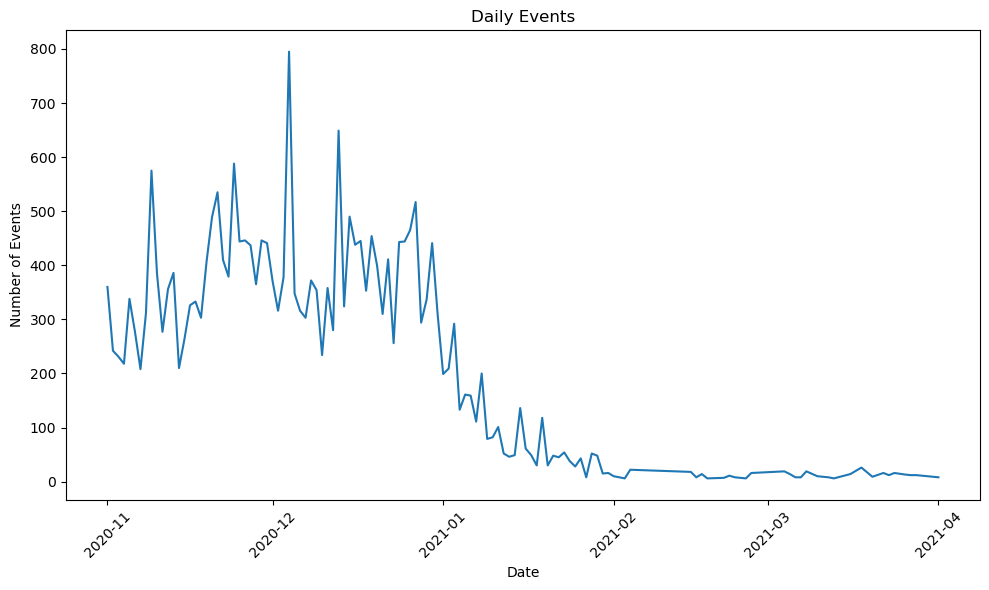

In [231]:
# Plot the data
plt.figure(figsize=(10, 6))
sns.lineplot(data=daily_events, x='dt', y='count')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.title('Daily Events')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [220]:
# Group by year and month and calculate the total number of events
daily_events['weekly'] = total_events['dt'].dt.to_period('W')
weekly_events = daily_events.groupby(by='weekly')['count'].mean().reset_index()
weekly_events['weekly'] = weekly_events['weekly'].dt.to_timestamp()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

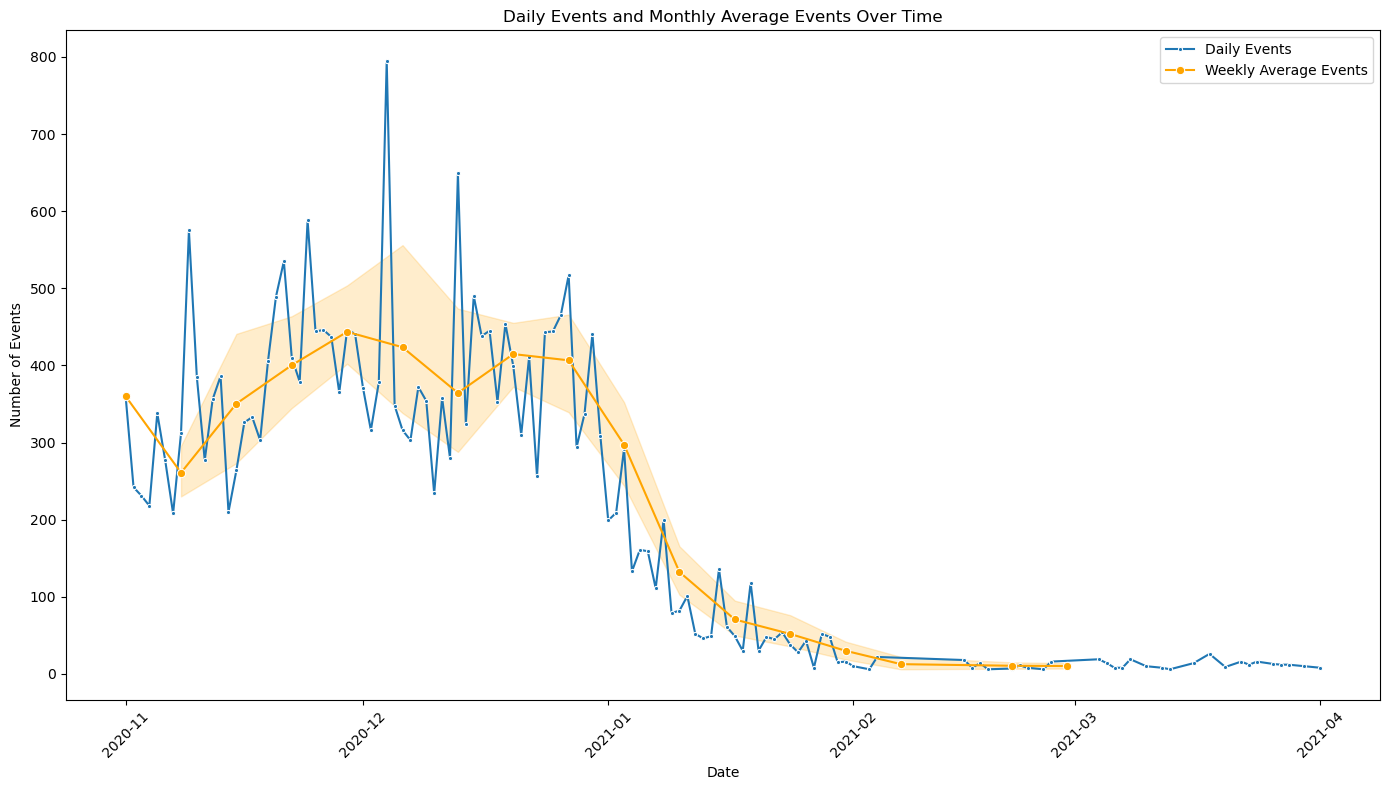

In [221]:
# Plot the data
plt.figure(figsize=(14, 8))

# Plot daily event counts
sns.lineplot(data=daily_events, x='dt', y='count', marker='.', label='Daily Events')

# Plot monthly average event counts
sns.lineplot(data=daily_events, x='weekly', y='count', marker='o', label='Weekly Average Events', color='orange')

plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.title('Daily Events and Weekly Average')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [223]:
print(weekly_events)

       weekly       count
0  2020-10-26  360.000000
1  2020-11-02  260.857143
2  2020-11-09  350.428571
3  2020-11-16  400.285714
4  2020-11-23  443.571429
5  2020-11-30  423.571429
6  2020-12-07  364.285714
7  2020-12-14  414.714286
8  2020-12-21  406.571429
9  2020-12-28  297.285714
10 2021-01-04  132.142857
11 2021-01-11   70.571429
12 2021-01-18   51.857143
13 2021-01-25   30.000000
14 2021-02-01   12.666667
15 2021-02-15   10.600000
16 2021-02-22   10.250000


**Observations:**
* It looks like around the first week of January 2023 the total number of daily events started dropping drastically. Around February 2023, the average weekly events stabilized at around 10 (as compared to roughly 350 weekly events during previous months).

In [323]:
# Group by year and month and calculate the total number of events
event_counts['weekly'] = event_counts['dt'].dt.to_period('W')
weekly_per_event = event_counts.groupby(by=['event_name','weekly'])['count'].mean().reset_index()
weekly_per_event['weekly'] = weekly_per_event['weekly'].dt.to_timestamp()

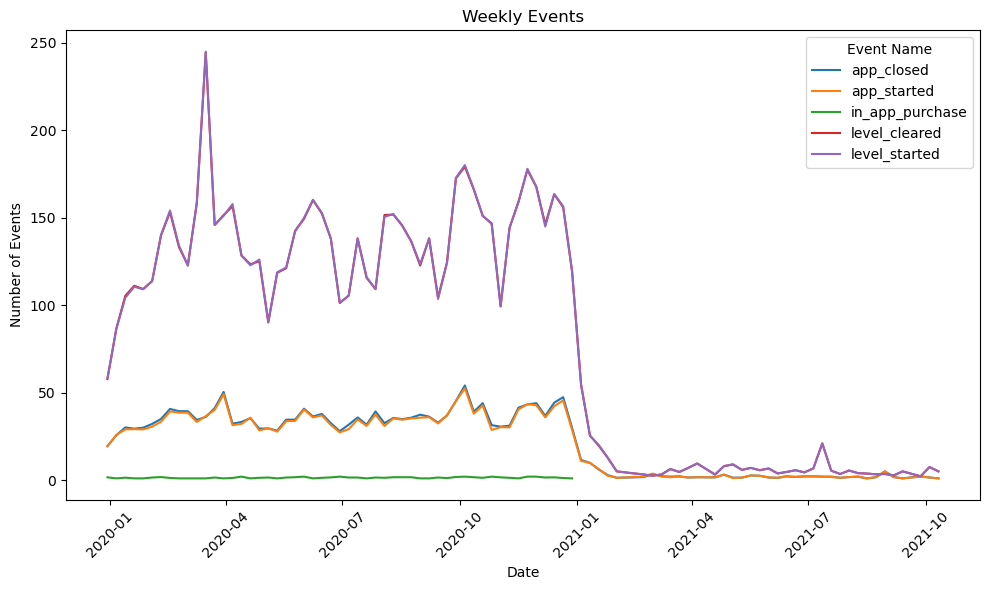

In [326]:
# Plot the data
plt.figure(figsize=(10, 6))
sns.lineplot(data=weekly_per_event, x='weekly', y='count', hue='event_name')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.title('Weekly Events')
plt.xticks(rotation=45)
plt.legend(title='Event Name')
plt.tight_layout()
plt.show()

**Observations:**
* It looks like all events we contributing to some degree

## App Store Level

In [243]:
display("Sales from Appstore", sales_from_appstores_df.head(5), sales_from_appstores_df.tail(5), sales_from_appstores_df.shape)

'Sales from Appstore'

,dt,app_id,app,platform,country_iso,type,content_id,price_usd,downloads,gross_revenue
0,2020-01-01,10,Fun App,Pear,AA,app,app.funapp,0.00,321,0.00
1,2020-01-01,30,Racing App,Pear,AA,app,app.raceapp,0.00,430,0.00
2,2020-01-01,10,Fun App,Pear,AA,in-app,app.funapp.toycar,0.99,43,42.57
3,2020-01-01,10,Fun App,Pear,AA,in-app,app.funapp.doll,0.99,34,33.66
4,2020-01-01,10,Fun App,Pear,AA,in-app,app.funapp.dollhouse,2.99,33,98.67


,dt,app_id,app,platform,country_iso,type,content_id,price_usd,downloads,gross_revenue
137830,2023-12-31,10,Fun App,Cyborg,EE,in-app,app.funapp.dollhouse,2.99,139,415.61
137831,2023-12-31,30,Racing App,Cyborg,EE,in-app,app.raceapp.bluecar,0.99,94,93.06
137832,2023-12-31,30,Racing App,Cyborg,EE,in-app,app.raceapp.redcar,1.99,254,505.46
137833,2023-12-31,30,Racing App,Cyborg,EE,in-app,app.raceapp.whitecar,1.99,91,181.09
137834,2023-12-31,30,Racing App,Cyborg,EE,in-app,app.raceapp.silvercar,2.99,68,203.32


(137835, 10)

In [244]:
check_data(sales_from_appstores_df)

,column,dtype,instances,unique,sum_null,duplicates
0,dt,object,137835,1461,0,0
1,app_id,int64,137835,3,0,0
2,app,object,137835,3,0,0
3,platform,object,137835,2,0,0
4,country_iso,object,137835,5,0,0
5,type,object,137835,2,0,0
6,content_id,object,137835,10,0,0
7,price_usd,float64,137835,4,0,0
8,downloads,int64,137835,2038,0,0
9,gross_revenue,float64,137835,2571,0,0


In [311]:
sales_from_appstores_df.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
dt,137835,2022-01-14 21:24:17.002938112,2020-01-01 00:00:00,2021-01-17 00:00:00,2022-02-01 00:00:00,2023-01-12 00:00:00,2023-12-31 00:00:00,NaN
app_id,137835.0,21.058149,10.0,10.0,30.0,30.0,30.0,9.708735
price_usd,137835.0,1.415742,0.0,0.99,0.99,1.99,2.99,1.041999
downloads,137835.0,211.158697,7.0,57.0,112.0,248.0,3691.0,271.155525
gross_revenue,137835.0,162.112944,-674.19,33.66,102.96,214.92,3654.09,205.264782
month,137835,2021-12-31 03:55:00.685602304,2020-01-01 00:00:00,2021-01-01 00:00:00,2022-02-01 00:00:00,2023-01-01 00:00:00,2023-12-01 00:00:00,NaN


**Observations:**
* Sales from App Stores for 3 apps.
* No aparent issues with the data (No duplicates or nulls)


In [345]:
sales_from_appstores_df.groupby(by='app').describe().transpose()

app                          Drawing App                        Fun App  \
dt            count                 6370                          58440   
              mean   2022-11-17 00:00:00  2021-12-30 23:59:59.999999744   
              min    2022-01-03 00:00:00            2020-01-01 00:00:00   
              25%    2022-06-11 00:00:00            2020-12-31 00:00:00   
              50%    2022-11-17 00:00:00            2021-12-31 00:00:00   
              75%    2023-04-25 00:00:00            2022-12-31 00:00:00   
              max    2023-10-01 00:00:00            2023-12-31 00:00:00   
              std                    NaN                            NaN   
app_id        count               6370.0                        58440.0   
              mean                  20.0                           10.0   
              min                   20.0                           10.0   
              25%                   20.0                           10.0   
              50%                   20.0                           10.0   
              75%                   20.0                           10.0   
              max                   20.0                           10.0   
              std                    0.0                            0.0   
price_usd     count               6370.0                        58440.0   
              mean                  0.99                         1.2425   
              min                   0.99                            0.0   
              25%                   0.99                         0.7425   
              50%                   0.99                           0.99   
              75%                   0.99                           1.49   
              max                   0.99                           2.99   
              std                    0.0                       1.086871   
downloads     count               6370.0                        58440.0   
              mean            540.744427                     210.158676   
              min                   66.0                            7.0   
              25%                  267.0                           59.0   
              50%                  430.5                          115.0   
              75%                 682.75                          247.0   
              max                 3691.0                         3596.0   
              std             399.192967                     263.727497   
gross_revenue count               6370.0                        58440.0   
              mean            534.812609                     127.558608   
              min                -674.19                        -281.06   
              25%                 263.34                            0.0   
              50%                  425.7                          81.18   
              75%               675.9225                         170.43   
              max                3654.09                        2529.54   
              std             395.910478                     162.953814   

app                                     Racing App  
dt            count                          73025  
              mean   2021-12-31 02:34:47.778158336  
              min              2020-01-01 00:00:00  
              25%              2020-12-31 00:00:00  
              50%              2021-12-31 00:00:00  
              75%              2022-12-31 00:00:00  
              max              2023-12-31 00:00:00  
              std                              NaN  
app_id        count                        73025.0  
              mean                            30.0  
              min                             30.0  
              25%                             30.0  
              50%                             30.0  
              75%                             30.0  
              max                             30.0  
              std                              0.0  
price_usd     count    

💡 **Observations:**
* This dataset contains over 3 years worth data from January 2020 to December 2023.
* The "Racing App" game contains over 3 years worth data from January 2020 to December 2023.

In [309]:
apps_list = sales_from_appstores_df['app'].unique().tolist()
sales_from_appstores_df['month'] = sales_from_appstores_df['dt'].dt.to_period('M')
sales_from_appstores_df['month'] = sales_from_appstores_df['month'].dt.to_timestamp()

In [300]:
sales_from_appstores_df.head()

,dt,app_id,app,platform,country_iso,type,content_id,price_usd,downloads,gross_revenue,month
0,2020-01-01,10,Fun App,Pear,AA,app,app.funapp,0.00,321,0.00,2020-01
1,2020-01-01,30,Racing App,Pear,AA,app,app.raceapp,0.00,430,0.00,2020-01
2,2020-01-01,10,Fun App,Pear,AA,in-app,app.funapp.toycar,0.99,43,42.57,2020-01
3,2020-01-01,10,Fun App,Pear,AA,in-app,app.funapp.doll,0.99,34,33.66,2020-01
4,2020-01-01,10,Fun App,Pear,AA,in-app,app.funapp.dollhouse,2.99,33,98.67,2020-01


In [301]:
racing_app = sales_from_appstores_df['app'] == 'Racing App'

In [302]:
period = (sales_from_appstores_df['dt'] >= "2020-11-01") & (sales_from_appstores_df['dt'] < "2021-04-01")

In [303]:
event_counts = sales_from_appstores_df[racing_app & period].groupby(['dt', 'app'])['downloads'].sum().reset_index()

In [304]:
print(event_counts)

            dt         app  downloads
0   2020-11-01  Racing App       5427
1   2020-11-02  Racing App       4919
2   2020-11-03  Racing App       5875
3   2020-11-04  Racing App       4933
4   2020-11-05  Racing App      10035
..         ...         ...        ...
146 2021-03-27  Racing App      13661
147 2021-03-28  Racing App       6470
148 2021-03-29  Racing App       5837
149 2021-03-30  Racing App       6574
150 2021-03-31  Racing App       6059

[151 rows x 3 columns]


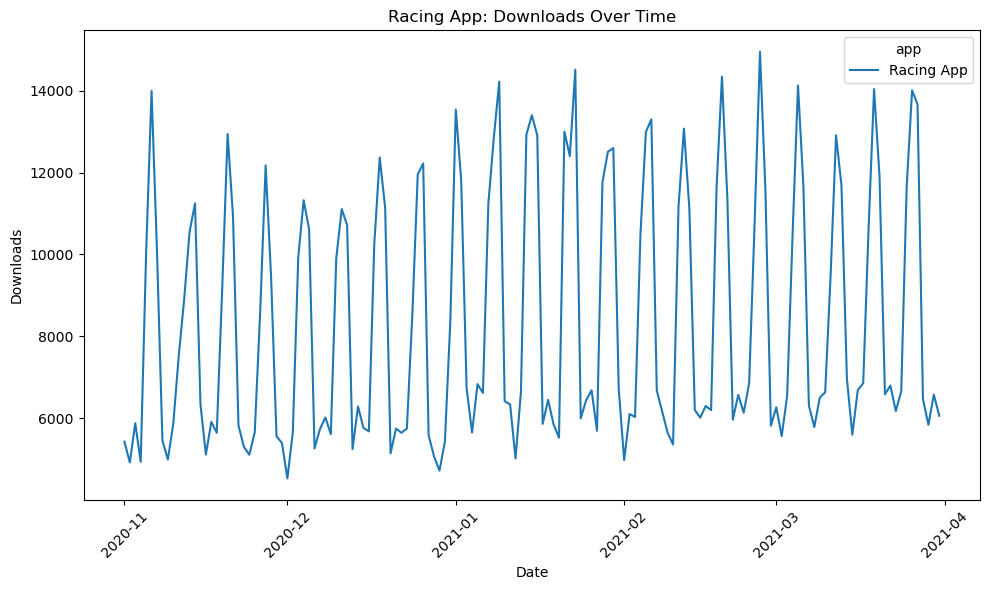

In [305]:
# Plot the data
plt.figure(figsize=(10, 6))
sns.lineplot(data=event_counts, x='dt', y='downloads', hue='app')
plt.xlabel('Date')
plt.ylabel('Downloads')
plt.title('Racing App: Downloads Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [306]:
event_counts = sales_from_appstores_df[racing_app & period].groupby(['dt', 'type'])['downloads'].sum().reset_index()

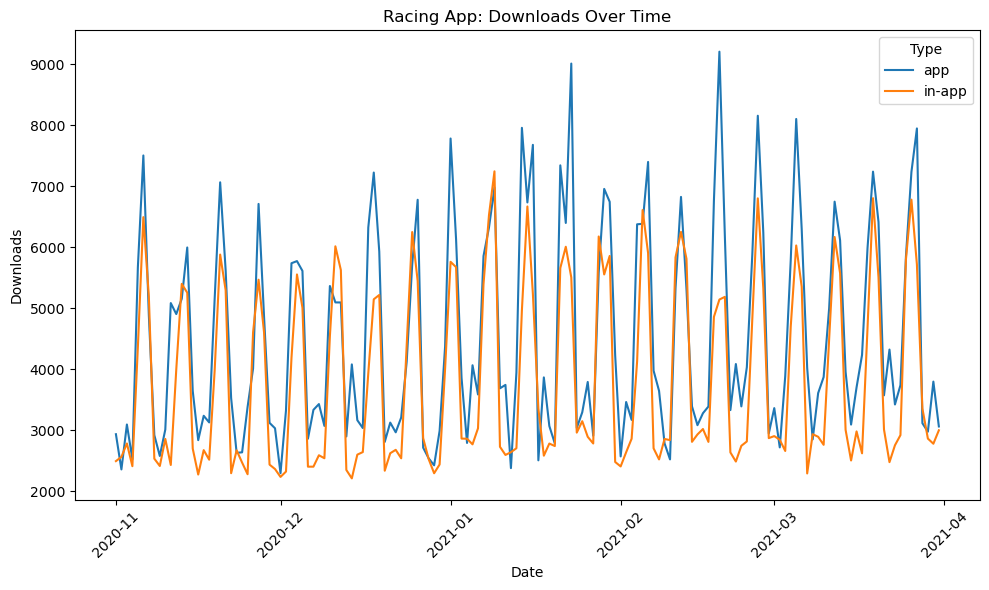

In [307]:
# Plot the data
plt.figure(figsize=(10, 6))
sns.lineplot(data=event_counts, x='dt', y='downloads', hue='type')
plt.xlabel('Date')
plt.ylabel('Downloads')
plt.title('Racing App: Downloads Over Time')
plt.xticks(rotation=45)
plt.legend(title='Type')
plt.tight_layout()
plt.show()

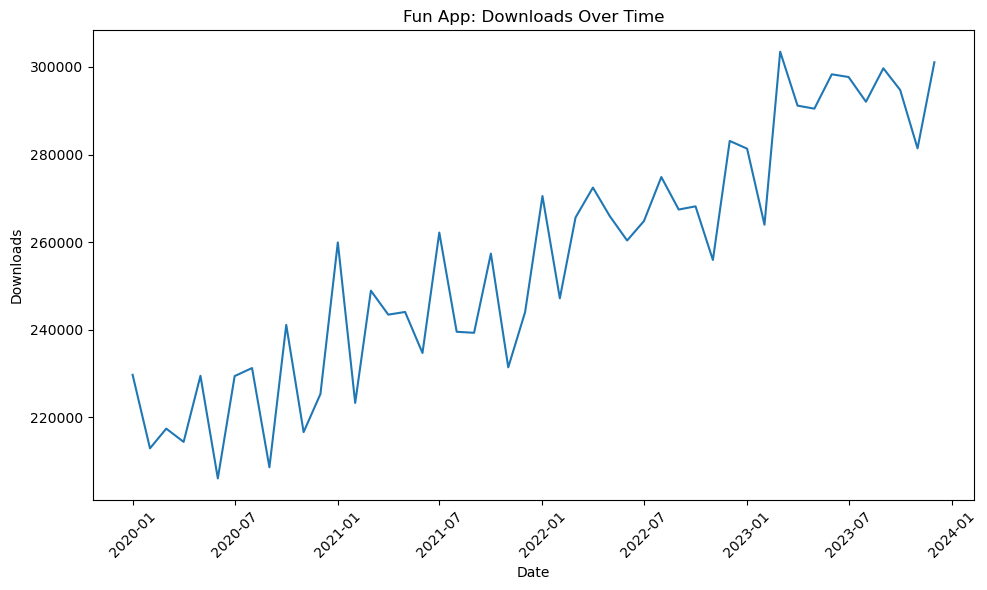

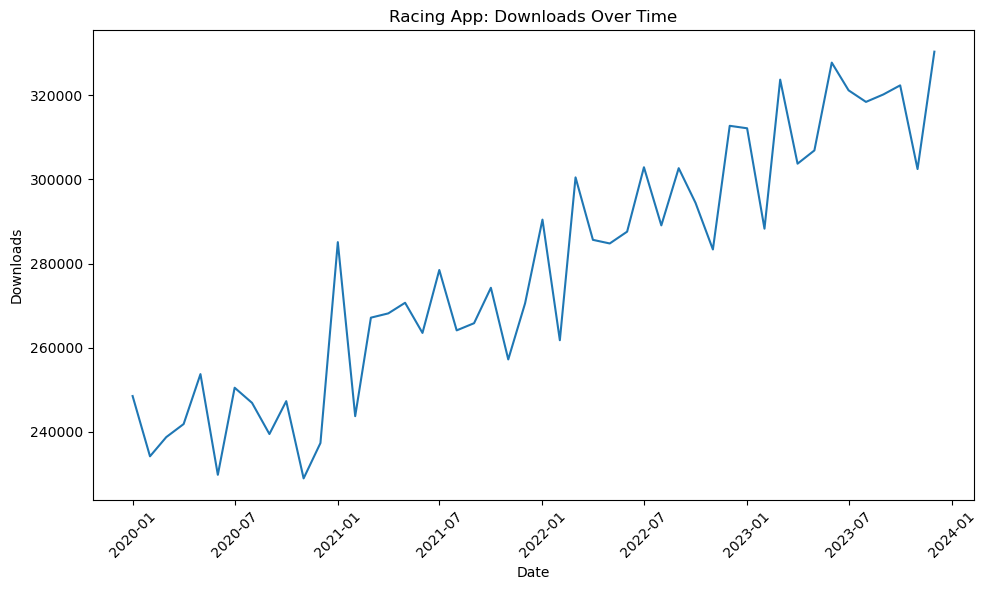

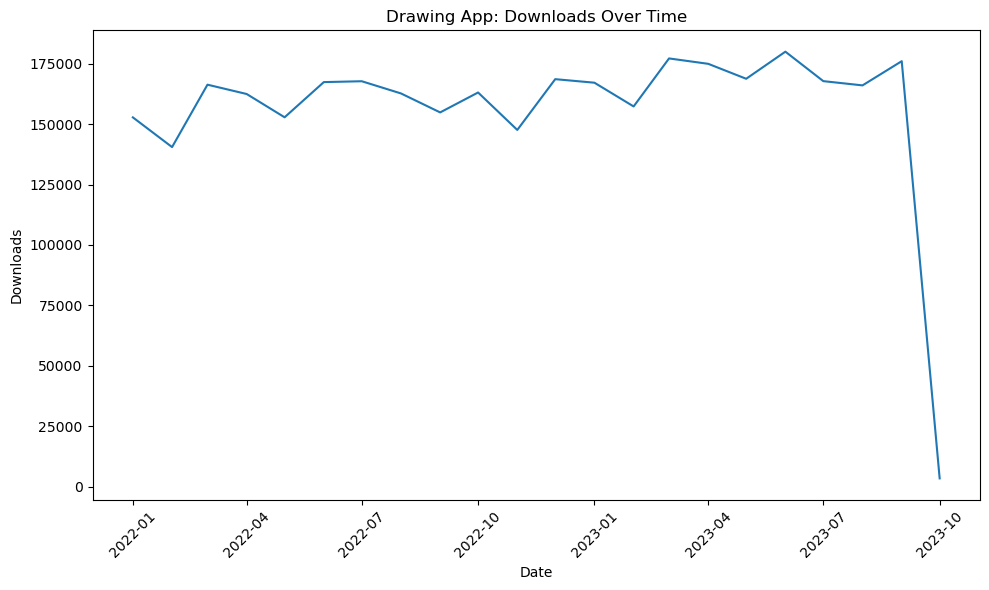

In [310]:
for app in apps_list:
    filter = sales_from_appstores_df['app'] == app
    event_counts = sales_from_appstores_df[filter].groupby(['month', 'app'])['downloads'].sum().reset_index()
    
     # Plot the data
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=event_counts, x='month', y='downloads')
    plt.xlabel('Date')
    plt.ylabel('Downloads')
    plt.title(f'{app}: Downloads Over Time')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

**Observations:**
* Both "Fun App" and "Racing App" had a continues upward trend for downloads between January 2020 and December 2023.
* For the "Drawing App" we seemed to stop getting downloads around September 2023, unlike for "Racing App" and "Fun App" which continued to get downloads until December 2023

## Results

List of issues:

**Overview**</br>
* **Missing in-app-purchase data:** We see that `in-app-purchase` data for the "Racing App" was not available after January 2021. One possible explanation is that in-app-purchases were no longer available after that date, but after investigating the `sales_from_appstores` data we can confirm that users were still making in-app purchases.
* **Decline in triggered events:** We see a decline in trigerred events that started around January 2021 (stabilized February 2021). This decline is significant, and after looking at the `sales_from_appstores` data we can confirm that users were still downloading the app and making in-app purchases during that time, therefore the issue may come from the event analytics tool (e.g. Problem with Firebase SDK integration).

**User Level:**<br>
Issues found specific to the user level data
* **Duplicates:** Since the data is aggregated at the daily level (no timestamp) and there is no UUID, its difficult to determine if duplicate events are simply due to the same event being triggered multiple times by the same user or if there is infact duplicates in the data. But you can't clear the same level twice. 
* **Missing countries:** The missing countries could be due to several factors:
    * If country info comes from user registration then this information may not be available because users never provided the information
    * If country info comes from the location where the event was triggered, then different technical issues may make it difficult to extract this data.
* **Spike in level events:** Huge spike in level events (`level_started and level_cleared`) triggered on March 17, 2020. Looks like this spike can be attributed to a single user who started around 788 events on that day. This was user `4c35e1d1-20c4-412f-8b81-1b273fe61f69`.


**Appstore Level**<br>
Issues found specific to the app store data
* **Drawing App download decline:** The "Drawing App" we seemed to stop getting downloads around September 2023, unlike for "Racing App" and "Fun App" which continued to get downloads until December 2023